In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import os.path
from math import floor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
# load the data
_data = np.load('res/data1.npy', allow_pickle=True).tolist()
saps_ii = _data['saps_ii']
X_train, X_val, X_test = _data['X_train'], _data['X_val'], _data['X_test']
Y_train, Y_val, Y_test = _data['Y_train'], _data['Y_val'], _data['Y_test']
print("Loaded!")

Loaded!


In [3]:
# Check that the data has been loaded correctly (outputs should be the same as in data_split.ipynb)
print("No. of patients: {}".format(len(saps_ii)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of patients who died in hospital in train, val, test sets: {}, {}, {}".format(sum(Y_train), sum(Y_val), sum(Y_test)))
print("Proportion of patients who died in hospital in train, val, test sets: {}%, {}%, {}%".format(round(sum(Y_train)/len(Y_train)*100,3), round(sum(Y_val)/len(Y_val)*100,3), round(sum(Y_test)/len(Y_test)*100,3)))

No. of patients: 38628
No. of patients in train, val, test sets: 27039, 5794, 5795
No. of patients who died in hospital in train, val, test sets: 3039, 678, 685
Proportion of patients who died in hospital in train, val, test sets: 11.239%, 11.702%, 11.821%


In [4]:
# Show example of one patient
labels = ['Age', 'Heart Rate', 'Systolic BP', 'Temperature', 'PaO2/FiO2', 'Urine Output', 'BUN', \
          'WBC', 'Potassium', 'Sodium', 'Bicarbonate', 'Bilirubin', 'GCS', 'Comorbidity', 'Admission Type']

patient = 2
for feature in range(len(labels)):
    print('{}: {}'.format(labels[feature], X_train[patient,feature]))
print('Outcome: {}'.format('Died in hospital' if Y_train[patient]==1 else 'Survived'))

Age: 38.93
Heart Rate: 120.0
Systolic BP: 130.0
Temperature: 38.3888880411784
PaO2/FiO2: None
Urine Output: 1110.0
BUN: 10.0
WBC: 8.1
Potassium: 3.6
Sodium: 139.0
Bicarbonate: 29.0
Bilirubin: None
GCS: 15.0
Comorbidity: None
Admission Type: Medical
Outcome: Survived


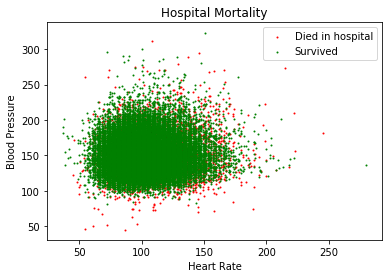

In [5]:
# Filter for patients that died in hospital
dead = saps_ii[saps_ii[:,-1] == 1]

# Filter for patients that survived
alive = saps_ii[saps_ii[:,-1] == 0]

# Plots
plt.scatter(dead[:,6], dead[:,7], s=1, label='Died in hospital', facecolor='r')
plt.scatter(alive[:,6], alive[:,7], s=1, label='Survived', facecolor='g')
plt.legend()
plt.xlabel('Heart Rate')
plt.ylabel('Blood Pressure')
plt.title('Hospital Mortality')
plt.show()

In [6]:
# Combine training and validation sets
X_train = np.concatenate((X_train,X_val))
X_test = X_test
Y_train = np.concatenate((Y_train,Y_val))
Y_test = Y_test

print("Shape of X_train: {}".format(np.shape(X_train)))
print("Shape of Y_train: {}".format(np.shape(Y_train)))
print("Shape of X_test: {}".format(np.shape(X_test)))
print("Shape of Y_test: {}".format(np.shape(Y_test)))

Shape of X_train: (32833, 15)
Shape of Y_train: (32833,)
Shape of X_test: (5795, 15)
Shape of Y_test: (5795,)


In [7]:
# Convert PaO2/FiO2 to binary variable in X_train and X_test
X_train[:,4][X_train[:,4] != None] = 1
X_train[:,4][X_train[:,4] == None] = 0
X_test[:,4][X_test[:,4] != None] = 1
X_test[:,4][X_test[:,4] == None] = 0

In [8]:
# Convert Bilirubin to binary variable in X_train and X_test
X_train[:,11][X_train[:,11] != None] = 1
X_train[:,11][X_train[:,11] == None] = 0
X_test[:,11][X_test[:,11] != None] = 1
X_test[:,11][X_test[:,11] == None] = 0

In [9]:
# Create a one-hot comorbidity matrix for X_train
comorb_X_train = np.zeros((len(X_train),len(np.unique(X_train[:,13]))))
for i in range(len(np.unique(X_train[:,13]))):
    comorb = np.unique(X_train[:,13])[i]
    comorb_X_train[:,i][X_train[:,13] == comorb] = 1
    comorb_X_train[:,i][X_train[:,13] != comorb] = 0

# Create a one-hot comorbidity matrix for X_test
comorb_X_test = np.zeros((len(X_test),len(np.unique(X_test[:,13]))))
for i in range(len(np.unique(X_test[:,13]))):
    comorb = np.unique(X_test[:,13])[i]
    comorb_X_test[:,i][X_test[:,13] == comorb] = 1
    comorb_X_test[:,i][X_test[:,13] != comorb] = 0

In [10]:
# Create a one-hot admission type matrix for X_train
adm_X_train = np.zeros((len(X_train),len(np.unique(X_train[:,14]))))
for i in range(len(np.unique(X_train[:,14]))):
    adm = np.unique(X_train[:,14])[i]
    adm_X_train[:,i][X_train[:,14] == adm] = 1
    adm_X_train[:,i][X_train[:,14] != adm] = 0

# Create a one-hot admission type matrix for X_test
adm_X_test = np.zeros((len(X_test),len(np.unique(X_test[:,14]))))
for i in range(len(np.unique(X_test[:,14]))):
    adm = np.unique(X_test[:,14])[i]
    adm_X_test[:,i][X_test[:,14] == adm] = 1
    adm_X_test[:,i][X_test[:,14] != adm] = 0

In [11]:
# Remove the comorbidity and admission type features in X_train and X_test
X_train = np.delete(X_train, [13,14], 1)
X_test = np.delete(X_test, [13,14], 1)

# Append the comorbity matrix to X_train and X_test
X_train = np.concatenate((X_train,comorb_X_train),1)
X_test = np.concatenate((X_test,comorb_X_test),1)

# Append the admission type matrix to X_train and X_test
X_train = np.concatenate((X_train,adm_X_train),1)
X_test = np.concatenate((X_test,adm_X_test),1)

In [12]:
# Now check how many patients are missing data
saps_ii = np.concatenate((X_train,X_test))
m = len(saps_ii)
num_missing = np.sum(saps_ii==None,1)
num_features = np.shape(saps_ii)[1]
pct_missing = num_missing/num_features * 100
bins = np.array(range(num_features+1))
for num in bins:
    diff = bins[2] - bins[1]
    print("Patients with {} feature{} missing: {}% ({}/{})".format(num, "" if num==1 else "s", round(sum(num_missing==num)/m*100,2), sum(num_missing==num), m))

Patients with 0 features missing: 93.08% (35956/38628)
Patients with 1 feature missing: 3.95% (1524/38628)
Patients with 2 features missing: 0.4% (156/38628)
Patients with 3 features missing: 0.21% (82/38628)
Patients with 4 features missing: 0.12% (45/38628)
Patients with 5 features missing: 1.24% (480/38628)
Patients with 6 features missing: 0.09% (34/38628)
Patients with 7 features missing: 0.04% (14/38628)
Patients with 8 features missing: 0.05% (19/38628)
Patients with 9 features missing: 0.02% (8/38628)
Patients with 10 features missing: 0.8% (310/38628)
Patients with 11 features missing: 0.0% (0/38628)
Patients with 12 features missing: 0.0% (0/38628)
Patients with 13 features missing: 0.0% (0/38628)
Patients with 14 features missing: 0.0% (0/38628)
Patients with 15 features missing: 0.0% (0/38628)
Patients with 16 features missing: 0.0% (0/38628)
Patients with 17 features missing: 0.0% (0/38628)
Patients with 18 features missing: 0.0% (0/38628)
Patients with 19 features missing

In [13]:
# Extract a smaller dataset with no missing features
Y = np.concatenate((Y_train, Y_test))
print("Shape of saps_ii: {}".format(np.shape(saps_ii)))
saps_ii_full = np.concatenate((saps_ii,Y[:,None]),1)
print("Shape of saps_ii_full: {}".format(np.shape(saps_ii_full)))
saps_ii_dense = saps_ii_full[num_missing==0]
print("Shape of saps_ii_dense: {}".format(np.shape(saps_ii_dense)))

Shape of saps_ii: (38628, 20)
Shape of saps_ii_full: (38628, 21)
Shape of saps_ii_dense: (35956, 21)


In [14]:
# Randomly shuffle the newly created dense dataset
saps_ii = np.array(saps_ii_dense)
np.random.shuffle(saps_ii_dense)

# Split the data into training and test set
m = len(saps_ii_dense)
train_split, test_split = m*0.85, m*0.15 # make sure these numbers sum to m*1.0
train, test = \
    saps_ii_dense[:floor(train_split),:], \
    saps_ii_dense[floor(train_split):,:]

# Create input (X) and output (Y) arrays
X_train_dense, X_test_dense = train[:,:-1], test[:,:-1]
Y_train_dense, Y_test_dense = train[:,-1], test[:,-1]

In [15]:
# Print information about the created arrays
print("No. of patients: {}".format(len(saps_ii_dense)))
print("No. of features: {}".format(X_train_dense.shape[1]))
print("No. of patients in train and test sets: {}, {}".format(len(X_train_dense), len(X_test_dense)))
print("No. of patients who died in hospital in train and test sets: {}, {}".format(sum(Y_train_dense), sum(Y_test_dense)))
print("Proportion of patients who died in hospital in train and test sets: {}%, {}%".format(round(sum(Y_train_dense)/len(Y_train_dense)*100,3), round(sum(Y_test_dense)/len(Y_test_dense)*100,3)))

No. of patients: 35956
No. of features: 20
No. of patients in train and test sets: 30562, 5394
No. of patients who died in hospital in train and test sets: 3333, 603
Proportion of patients who died in hospital in train and test sets: 10.906%, 11.179%


In [16]:
# Convert all data to floats
X_train_dense = X_train_dense.astype(float)
Y_train_dense = Y_train_dense.astype(float)
X_test_dense = X_test_dense.astype(float)
Y_test_dense = Y_test_dense.astype(float)

In [17]:
# Create decision tree classifer object
decisionTree = DecisionTreeClassifier()

# Train decision tree classifer
decisionTree = decisionTree.fit(X_train_dense,Y_train_dense)

# Predict the response for test dataset
Y_pred = decisionTree.predict(X_test_dense)

In [18]:
# Show metrics for decision tree classifier
print("Metrics for decision tree classifier:")
print("")
print(metrics.classification_report(Y_test_dense, Y_pred, target_names = ["Survived", "Died"]))

Metrics for decision tree classifier:

              precision    recall  f1-score   support

    Survived       0.92      0.91      0.91      4791
        Died       0.31      0.33      0.32       603

    accuracy                           0.84      5394
   macro avg       0.61      0.62      0.62      5394
weighted avg       0.85      0.84      0.85      5394



In [19]:
# Show AUROC for decision tree classifier
print("AUROC for decision tree classifier:")
print("")
print(metrics.roc_auc_score(Y_test_dense, Y_pred))

AUROC for decision tree classifier:

0.6201267716936089


In [20]:
# Create logistic regression classifer object
logisticRegr = LogisticRegression(solver = "liblinear")

# Train logistic regression classifer
logisticRegr.fit(X_train_dense, Y_train_dense)

# Predict the response for test dataset
Y_pred = logisticRegr.predict(X_test_dense)

In [21]:
# Show metrics for logistic regression classifier
print("Metrics for logistic regression classifier:")
print("")
print(metrics.classification_report(Y_test_dense, Y_pred, target_names = ["Survived", "Died"]))

Metrics for logistic regression classifier:

              precision    recall  f1-score   support

    Survived       0.90      0.99      0.94      4791
        Died       0.57      0.14      0.23       603

    accuracy                           0.89      5394
   macro avg       0.74      0.56      0.58      5394
weighted avg       0.86      0.89      0.86      5394



In [22]:
# Show AUROC for logistic regression classifier
print("AUROC for logistic regression classifier:")
print("")
print(metrics.roc_auc_score(Y_test_dense, Y_pred))

AUROC for logistic regression classifier:

0.563906100887755
